# Programming Assignment - 04

## Deliverable 6

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

%matplotlib inline
plt.rcParams.update({'font.size': 14})

In [2]:
ancestry_data = pd.read_csv('TrainingData_N183_p10.csv')
print("shape: {}".format(ancestry_data.shape))

shape: (183, 11)


In [3]:
ancestry_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,-10.901171,0.798743,-1.143301,-1.070960,11.856396,-2.265965,4.536405,1.519959,-2.214294,-0.671274,African
1,-9.990054,1.416821,-0.729626,-0.443621,10.418594,0.443514,2.640659,-4.637746,3.351629,-0.671274,African
2,-9.345388,2.913054,-0.921421,0.029173,10.672615,-2.052552,5.140476,-1.451096,0.444183,-0.671274,African
3,-11.221507,1.733021,-2.339817,0.045786,13.195087,-3.068897,2.863434,-2.259194,2.374566,-0.671274,African
4,-10.175158,2.066307,-0.785493,-0.632400,7.461272,-1.643509,0.715258,-3.982752,0.098681,-0.671274,African


In [4]:
all_features = ancestry_data.columns[:-1]
prediction_variable =  ancestry_data.columns[-1]
quantitative_features = ancestry_data[:-1]
categories = list(ancestry_data[prediction_variable].unique())

In [5]:
X = ancestry_data[all_features].to_numpy()
N, p = X.shape
K = len(categories)
Y = ancestry_data[prediction_variable].to_numpy().reshape(N, 1)

In [6]:
bias = np.ones((N, 1)).reshape((N,1))
X = np.hstack((bias, X))

In [7]:
Y_k = np.zeros((N, K))

for i in range(N):
    cat_idx = categories.index(Y[i])
    Y_k[i, cat_idx] = 1

In [8]:
# utility methods

def error(X, Y, beta):
    return Y - np.matmul(X, beta)

def residual_sum_squares(X, Y, beta):
    e = error(X, Y, beta)
    return np.matmul(e.T, e)

def mean_squared_error(X, Y, beta):
    return residual_sum_squares(X, Y, beta) / len(X)

def Categorical_Cross_Entropy(X, Y, B, categories):
    N, p, = X.shape
    k = len(categories)
    U = np.vectorize(lambda a : np.exp(a))(np.matmul(X, B))
    P = np.zeros((N, K))
    for i in range(N):
        for j in range(K):
            P[i,j] = U[i,j] / np.sum(U[i])
    temp = np.vectorize(lambda a : np.log10(a))(P)
    temp = Y * temp
    return -np.sum(temp)/N
        

def standardize_data(data):
    rows, cols = data.shape
    for i in range(cols):
        data[:,i] = (data[:,i] - (data[:,i].mean())) / data[:,i].std()
    return data

def centralize_data(data):
    rows, cols = data.shape
    for i in range(cols):
        data[:,i] = (data[:,i] - (data[:,i].mean()))
    return data

def scale_folds_x(X_train, X_val):
    rows, cols = X_train.shape
    for i in range(cols):
        mean = X_train[:,i].mean()
        std = X_train[:,i].std()
        X_train[:,i] = (X_train[:,i] - mean) / std
        X_val[:,i] = (X_val[:,i] - mean) / std
    return X_train, X_val
    

def scale_folds(X_train, Y_train, X_val, Y_val):
    rows, cols = X_train.shape
    for i in range(cols):
        mean = X_train[:,i].mean()
        std = X_train[:,i].std()
        X_train[:,i] = (X_train[:,i] - mean) / std
        X_val[:,i] = (X_val[:,i] - mean) / std
        
    rows, cols = Y_train.shape
    for i in range(cols):
        mean = Y_train[:,i].mean()
        Y_train[:,i] = Y_train[:,i] - mean
        Y_val[:,i] = Y_val[:,i] - mean
        
    return X_train, Y_train, X_val, Y_val

def sign(arg):
    return -1 if arg < 0 else 1

def get_as_table(data):
    pTable = PrettyTable()
    pTable.clear()
    n = len(data)
    for i in range(n):
        pTable.add_row(data[i], divider=True)
    pTable.header = False
    return pTable

In [9]:
def logistic_ridge_regression(X, Y, learn_rate, penalty, max_itr, categories):
    N, p = X.shape
    K = len(categories)
    B = np.zeros((p, K))
    for _ in range(max_itr):
        U = np.exp(np.matmul(X, B))
        P = np.zeros((N, K))
        for i in range(N):
            for j in range(K):
                P[i,j] = U[i,j] / np.sum(U[i])

        Z = np.zeros((p, K))
        Z[0] = B[0]

        B = B + learn_rate * (np.matmul(X.T, Y - P) - 2 * penalty * (B - Z))
    return B

def logistic_ridge_cv(X, Y, k_folds, learn_rate, penalties, max_itr, categories):
    N, p = X.shape
    K = len(categories)
    batch_size = len(X) // k_folds
    n_penalties = len(penalties)
    CCE = np.zeros(n_penalties)
    B_history = np.zeros((n_penalties, p, K))
    
    for penalty_idx in range(n_penalties):
        B = 0
        start = 0
        cce_s = []
        for fold in range(k_folds):
            val_idx = range(start, min(N-1, start + batch_size))
            train_idx = [(i not in val_idx) for i in range(len(X))]
            
            X_train, X_val = X[train_idx], X[val_idx]
            X_train[:,1:], X_val[:,1:] = scale_folds_x(X_train[:,1:], X_val[:,1:])
            Y_train, Y_val = Y[train_idx], Y[val_idx]
            
            B = logistic_ridge_regression(X_train, Y_train, learn_rate, penalties[penalty_idx], max_itr, categories)
            cce = Categorical_Cross_Entropy(X_val, Y_val, B, categories)
            cce_s.append(cce)
            
            start = start + batch_size
        CCE[penalty_idx] = np.average(cce_s)
        B_history[penalty_idx] = B
    return B_history, CCE

In [10]:
learn_rate = 1e-5
penalties = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
k_folds = 5
max_itr = 10000

In [11]:
B_history, CCE = logistic_ridge_cv(X, Y_k, k_folds, learn_rate, penalties, max_itr, categories)

## Deliverable 1

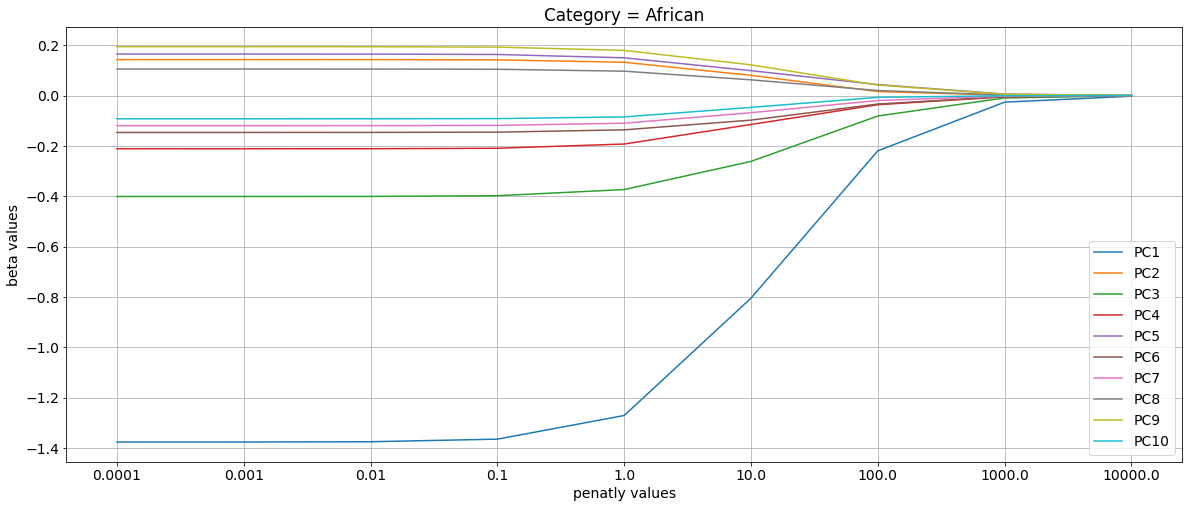

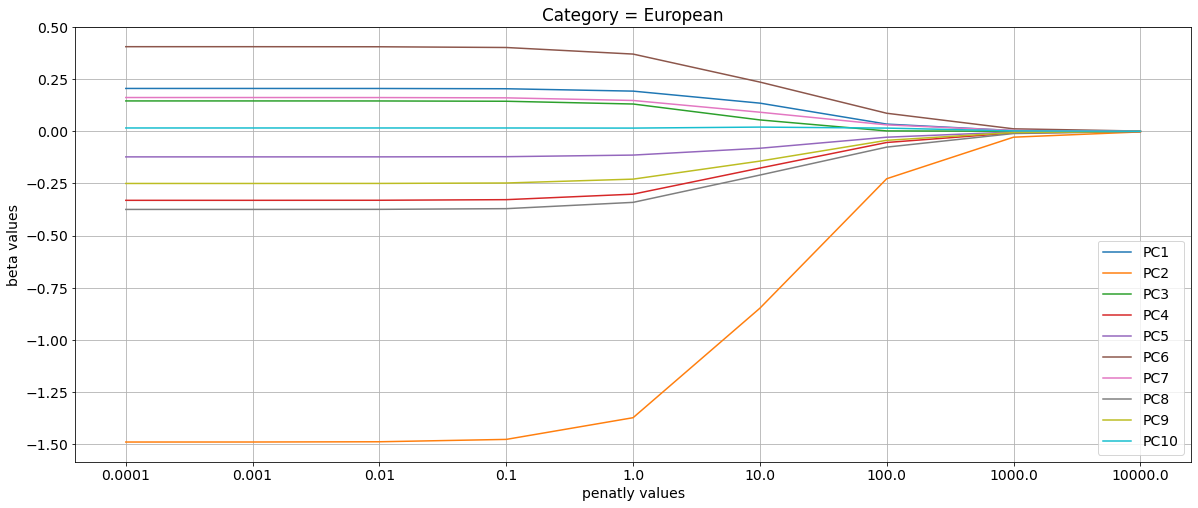

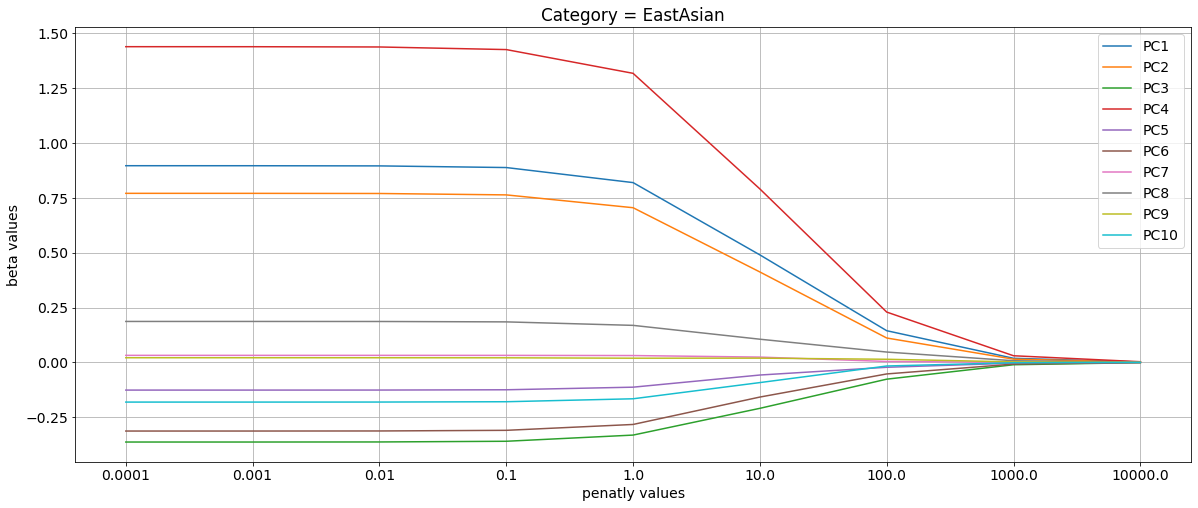

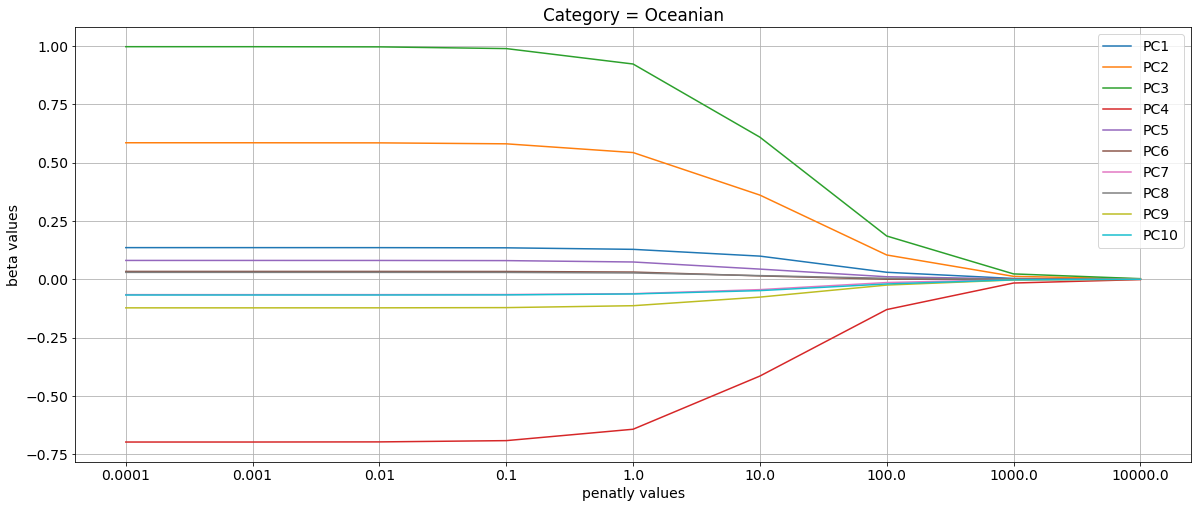

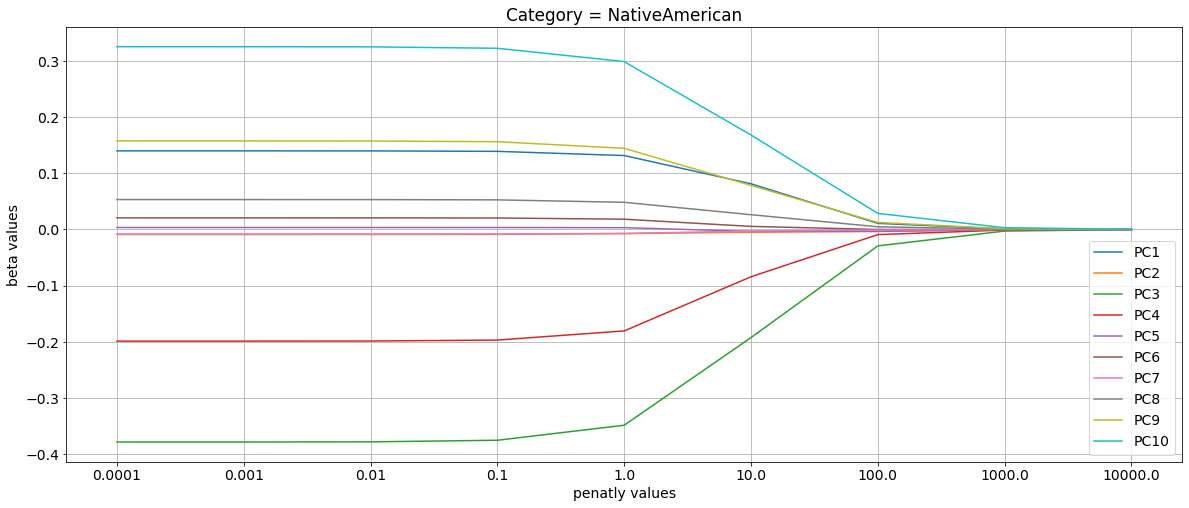

In [21]:
for k in range(len(categories)):
    plt.figure(figsize=(20,8))
    for i in range(0, p):
        plt.plot(B_history[:,i+1,k], label = all_features[i])
    plt.title(f'Category = {categories[k]}')
    plt.xlabel('penatly values')
    plt.ylabel('beta values')
    xlabels = [str(i) for i in penalties]
    plt.xticks(range(len(xlabels)), xlabels)
    plt.legend()
    plt.grid(True)
    plt.show()

## Deliverable 2

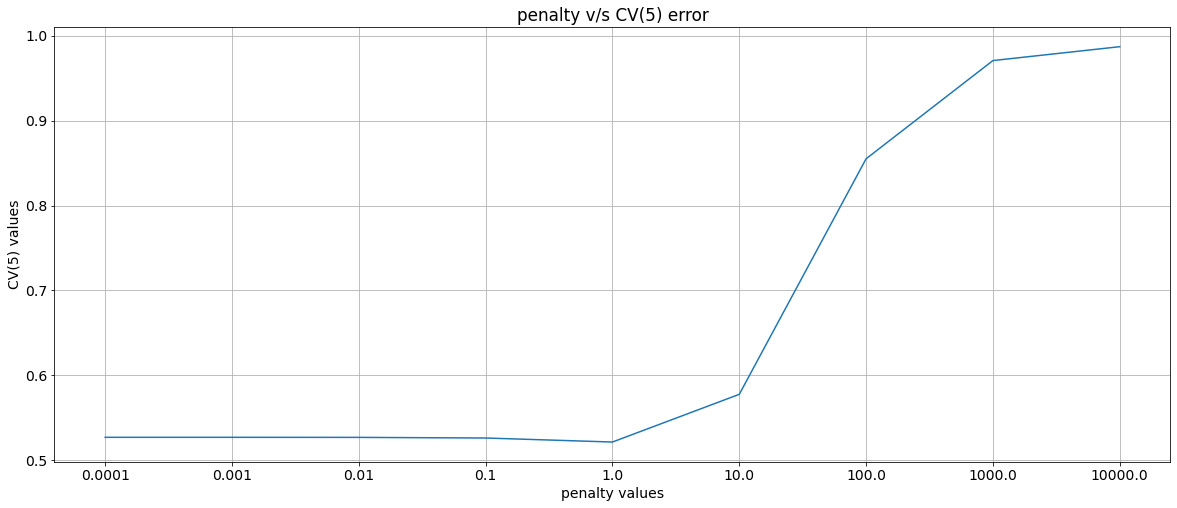

In [13]:
plt.figure(figsize=(20,8))
plt.plot(CCE)
plt.title(f'penalty v/s CV(5) error')
plt.xlabel('penalty values')
plt.ylabel('CV(5) values')
xlabels = [str(i) for i in penalties]
plt.xticks(range(len(xlabels)), xlabels)
plt.grid(True)
plt.show()

## Deliverable 3

In [14]:
min_cv5_idx = np.argmin(CCE, axis=None)
print("The value of 𝜆 that generated the smallest CV(5) error is,")
min_penalty = penalties[min_cv5_idx]
print(f'𝜆 = {min_penalty}')

The value of 𝜆 that generated the smallest CV(5) error is,
𝜆 = 1.0


In [15]:
X_scaled = X.copy()
X_scaled[:,1:], _ = scale_folds_x(X_scaled[:,1:], X_scaled[:,1:])
B_best = logistic_ridge_regression(X_scaled, Y_k, learn_rate, min_penalty, max_itr, categories)

## Deliverable 4

In [16]:
ancestry_data_test = pd.read_csv('TestData_N111_p10.csv')

In [17]:
X_test = ancestry_data_test[all_features].to_numpy()
N_test, p = X_test.shape
X_test = np.hstack((np.ones((N_test, 1)), X_test))
Y_test = ancestry_data_test[prediction_variable].to_numpy().reshape(N_test, 1)

In [18]:
XB = np.exp(np.matmul(X_test, B_best))
P_test = XB / np.sum(XB, axis=1)[:,None]

In [19]:
Y_predict = np.argmax(P_test, axis=1)
Y_predict = [categories[i] for i in Y_predict]
Y_predict = np.array(Y_predict).reshape(Y_test.shape)

In [20]:
print(get_as_table(np.vstack((['Actual', 'Prediction'] + categories, np.hstack((Y_test, Y_predict, np.round(P_test * 100, 4)))))))

+-----------------+----------------+---------+----------+-----------+----------+----------------+
|      Actual     |   Prediction   | African | European | EastAsian | Oceanian | NativeAmerican |
+-----------------+----------------+---------+----------+-----------+----------+----------------+
|     Unknown     |    Oceanian    |   0.0   |   0.0    |    0.0    |  100.0   |      0.0       |
+-----------------+----------------+---------+----------+-----------+----------+----------------+
|     Unknown     | NativeAmerican |   0.0   |  0.0005  |   0.0003  |  0.0002  |     99.999     |
+-----------------+----------------+---------+----------+-----------+----------+----------------+
|     Unknown     |    European    |  0.0023 | 98.4699  |   1.4607  |  0.0551  |     0.012      |
+-----------------+----------------+---------+----------+-----------+----------+----------------+
|     Unknown     |    African     | 99.8412 |   0.0    |   0.0001  |  0.1586  |     0.0001     |
+-----------------+-

## Deliverable 5

Many **Mexican** ancestries are classified as either **Native American** or **European** because as per history the Native Americans living in that area are colonized by the Europeans, especially by the Spanish so it is expected.

After the end of colonization they began calling themselves as **Mexicans**. Although there are outliers like **East Asian** and **Oceanian** ancestries they are very few.

Whereas all **African Americans** are classified as **Africans** because of the slave trade of their ancestors to North America.